In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict, Counter
from sklearn.decomposition import TruncatedSVD
import itertools
from scipy.stats import linregress
import plotly_express as px
import torch.nn.functional as F
import math
import seaborn as sns
from scipy.signal import savgol_filter

In [2]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_blowup_max_slope(dists: List[float], min_slope_threshold: float = 0.02):
    steps = list(range(len(dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = dists[i] - dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    if not any(np.array(slopes) > min_slope_threshold):
        return len(steps) - 1

    return np.argsort(np.nan_to_num(slopes))[::-1][0]


def find_blowup_point(kl_divergences, window_length=11, polyorder=3, threshold=2):
    """
    Find the blowup point using the 2nd derivative of KL divergences.

    Args:
    kl_divergences (array-like): KL divergence values at each step.
    window_length (int): The length of the Savitzky-Golay filter window.
    polyorder (int): The order of the polynomial used to fit the samples.
    threshold (float): The threshold for identifying a significant change in the 2nd derivative.

    Returns:
    int: The index of the detected blowup point.
    """
    # Smooth the KL divergences using Savitzky-Golay filter
    smoothed = savgol_filter(kl_divergences, window_length, polyorder)

    # Compute 1st and 2nd derivatives
    first_derivative = np.gradient(smoothed)
    second_derivative = np.gradient(first_derivative)

    # Normalize the 2nd derivative
    normalized_second_derivative = (
        second_derivative - np.mean(second_derivative)
    ) / np.std(second_derivative)

    # Find points where the normalized 2nd derivative exceeds the threshold
    potential_blowups = np.where(normalized_second_derivative > threshold)[0]

    if len(potential_blowups) > 0:
        # Return the first point that exceeds the threshold
        return potential_blowups[0]
    else:
        # If no point exceeds the threshold, return the point of maximum 2nd derivative
        return np.argmax(second_derivative)


def euclidean_distance_tensor_vector(tensor, vector):
    """
    Compute the Euclidean distance between each slice of a tensor and a vector.

    Args:
    tensor (torch.Tensor or np.ndarray): A tensor of shape (N, D) where N is the number of slices
                                         and D is the dimensionality of each slice.
    vector (torch.Tensor or np.ndarray): A vector of shape (D,)

    Returns:
    torch.Tensor or np.ndarray: A 1D array of Euclidean distances for each slice of the tensor
    """
    if isinstance(tensor, np.ndarray) and isinstance(vector, np.ndarray):
        return np.sqrt(np.sum((tensor - vector) ** 2, axis=1))
    elif isinstance(tensor, torch.Tensor) and isinstance(vector, torch.Tensor):
        return torch.sqrt(torch.sum((tensor - vector.unsqueeze(0)) ** 2, dim=1))
    else:
        raise TypeError("Both inputs must be either numpy arrays or PyTorch tensors")

In [3]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [4]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
sae.eval()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


In [60]:
metadata, activations = [], []

n_files = 10

for path in sorted(glob("observations_layer2/metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob("observations_layer2/acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [62]:
activations.shape

(3500, 100, 768)

## Individual perturbations explorations

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from scipy.stats import entropy
from scipy.signal import find_peaks

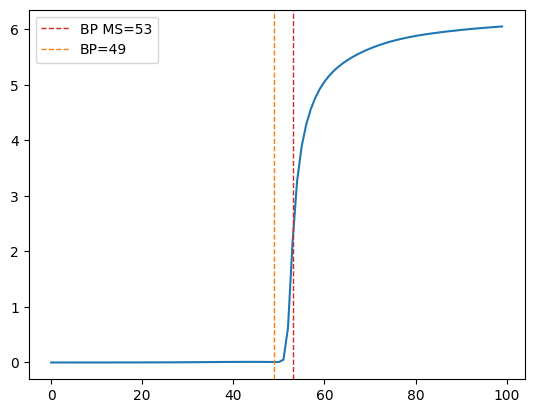

In [53]:
idx = 0

m = metadata[idx]
acts = activations[idx]

steps = m["steps_metadata"]
kl_div = [s["kl_div"] for s in steps]
bp = find_blowup_max_slope(kl_div)
bpp = find_blowup_point(kl_div)

plt.plot(kl_div)
plt.axvline(x=bp, color="tab:red", linestyle="--", linewidth=1, label=f"BP MS={bp}")
plt.axvline(x=bpp, color="tab:orange", linestyle="--", linewidth=1, label=f"BP={bpp}")
plt.legend()

In [33]:
# def plot_distribution_changes(interpolated, step_indices):
#     """
#     Plot distribution changes at specified steps.

#     :param interpolated: Interpolated activations
#     :param step_indices: List of step indices to plot
#     """
#     plt.figure(figsize=(12, 6))
#     for idx in step_indices:
#         kde = gaussian_kde(interpolated[idx])
#         x = np.linspace(interpolated[idx].min(), interpolated[idx].max(), 100)
#         plt.plot(x, kde(x), label=f'Step {idx}')
#     plt.xlabel('Activation Value')
#     plt.ylabel('Density')
#     plt.title('Activation Distribution Changes')
#     plt.legend()
#     plt.show()

# plot_distribution_changes(acts, [0, 25, 50, 75, 99])

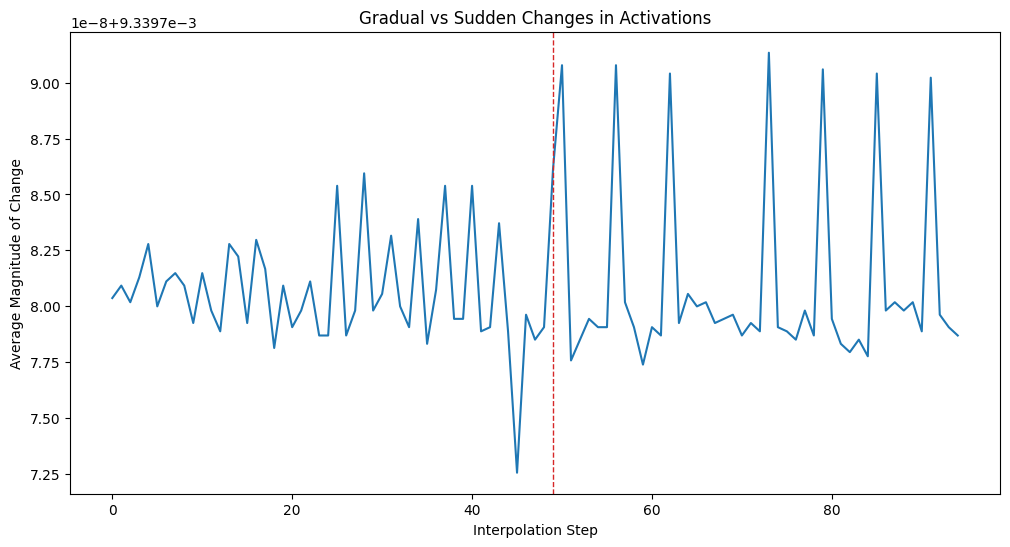

In [54]:
def analyze_gradual_vs_sudden(interpolated, window_size=5):
    """
    Analyze gradual vs sudden changes in activations.

    :param interpolated: Interpolated activations
    :param window_size: Size of the rolling window for change calculation
    :return: Array of change magnitudes
    """
    # changes = np.mean(np.abs(np.diff(interpolated, axis=0)), axis=1)
    changes = np.mean(np.abs(np.diff(interpolated, axis=0)), axis=1)
    rolling_avg = np.convolve(changes, np.ones(window_size) / window_size, mode="valid")
    return rolling_avg


def plot_gradual_vs_sudden(changes, bp):
    """
    Plot gradual vs sudden changes.

    :param changes: Array of change magnitudes
    """
    plt.figure(figsize=(12, 6))
    plt.plot(changes)
    plt.axvline(x=bp, color="tab:red", linestyle="--", linewidth=1, label="blowup")
    plt.xlabel("Interpolation Step")
    plt.ylabel("Average Magnitude of Change")
    plt.title("Gradual vs Sudden Changes in Activations")
    plt.show()


changes = analyze_gradual_vs_sudden(acts)
plot_gradual_vs_sudden(changes, bpp)

In [55]:
def find_max_change_point(changes):
    """Find the point of maximum change."""
    return np.argmax(np.diff(changes))


max_change_point = find_max_change_point(changes)
print(f"Point of maximum change: Step {max_change_point}")

Point of maximum change: Step 84


## Correlations at scale

In [63]:
def locate_dip(changes):
    """
    Locate the dip in the average magnitude of change.

    :param changes: Array of change magnitudes
    :return: Index of the dip
    """
    # Invert the changes to find the dip as a peak
    inverted = -changes
    peaks, _ = find_peaks(inverted, prominence=0.1 * np.std(inverted))
    if len(peaks) > 0:
        return peaks[np.argmax(inverted[peaks])]
    else:
        return np.argmin(changes)

In [64]:
blowup_points, dip_points = [], []

for idx, m in enumerate(metadata):
    m = metadata[idx]
    acts = activations[idx]
    kl_div = [s["kl_div"] for s in m["steps_metadata"]]
    changes = analyze_gradual_vs_sudden(acts)

    dip_index = locate_dip(changes)
    blowup_index = np.argmax(np.diff(kl_div))

    blowup_points.append(blowup_index)
    dip_points.append(dip_index)

In [65]:
len(blowup_points), len(dip_points)

(3500, 3500)

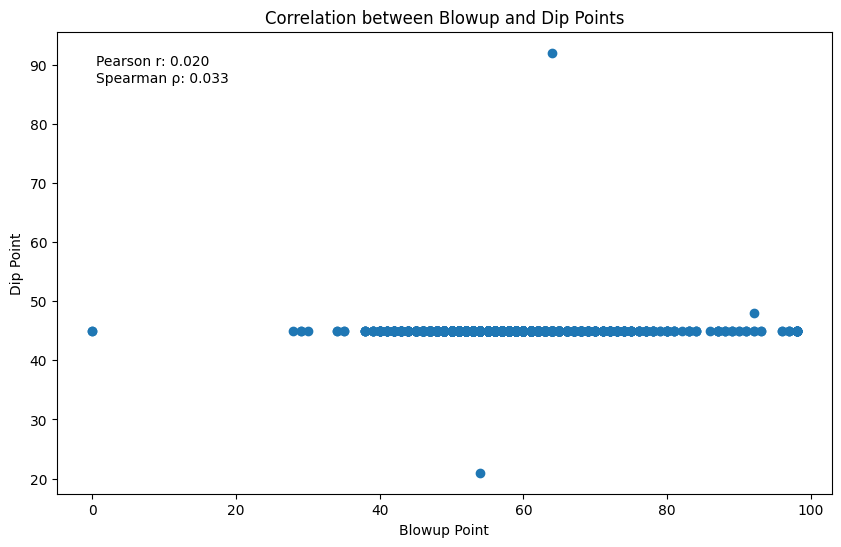

Pearson correlation: 0.01992887711753305 (0.2385)
Spearman correlation: 0.03262516599687839 (0.0536)


In [66]:
def compute_correlation(blowup_points, dip_points):
    """
    Compute correlation between blowup points and dip points.

    :param blowup_points: List of blowup points from multiple examples
    :param dip_points: List of dip points from multiple examples
    :return: Pearson and Spearman correlation coefficients
    """
    pearson_corr, p_value_pearson = stats.pearsonr(blowup_points, dip_points)
    spearman_corr, p_value_spearman = stats.spearmanr(blowup_points, dip_points)

    plt.figure(figsize=(10, 6))
    plt.scatter(blowup_points, dip_points)
    plt.xlabel("Blowup Point")
    plt.ylabel("Dip Point")
    plt.title("Correlation between Blowup and Dip Points")
    plt.text(
        0.05,
        0.95,
        f"Pearson r: {pearson_corr:.3f}\nSpearman ρ: {spearman_corr:.3f}",
        transform=plt.gca().transAxes,
        verticalalignment="top",
    )
    plt.show()

    return pearson_corr, p_value_pearson, spearman_corr, p_value_spearman


pearson_corr, p_value_pearson, spearman_corr, p_value_spearman = compute_correlation(
    blowup_points, dip_points
)
print(f"Pearson correlation: {pearson_corr} ({p_value_pearson:.4f})")
print(f"Spearman correlation: {spearman_corr} ({p_value_spearman:.4f})")